imported
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating RawArray with float64 data, n_channels=5440, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


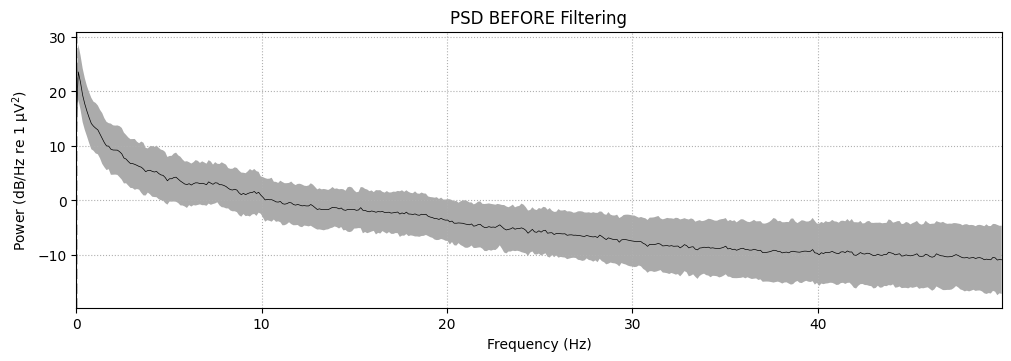

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)



/tmp/ipython-input-2843324101.py:48: RuntimeWarning: filter_length (7921) is longer than the signal (7794), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=0.1, h_freq=20.0, fir_design='firwin')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


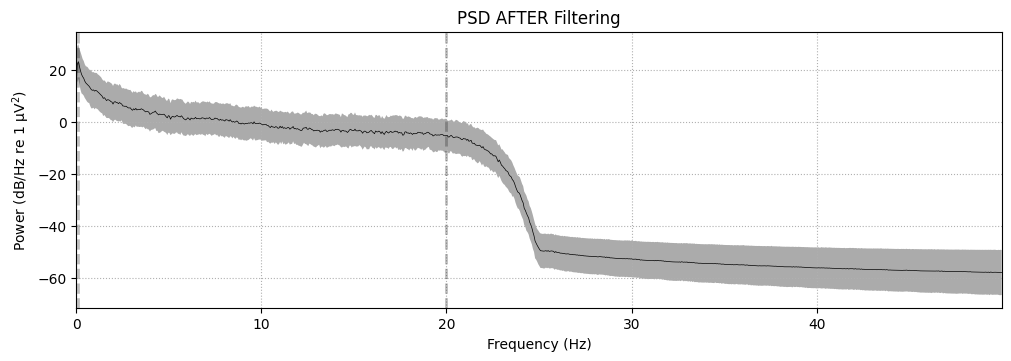

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components
Fitting ICA took 6.0s.


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


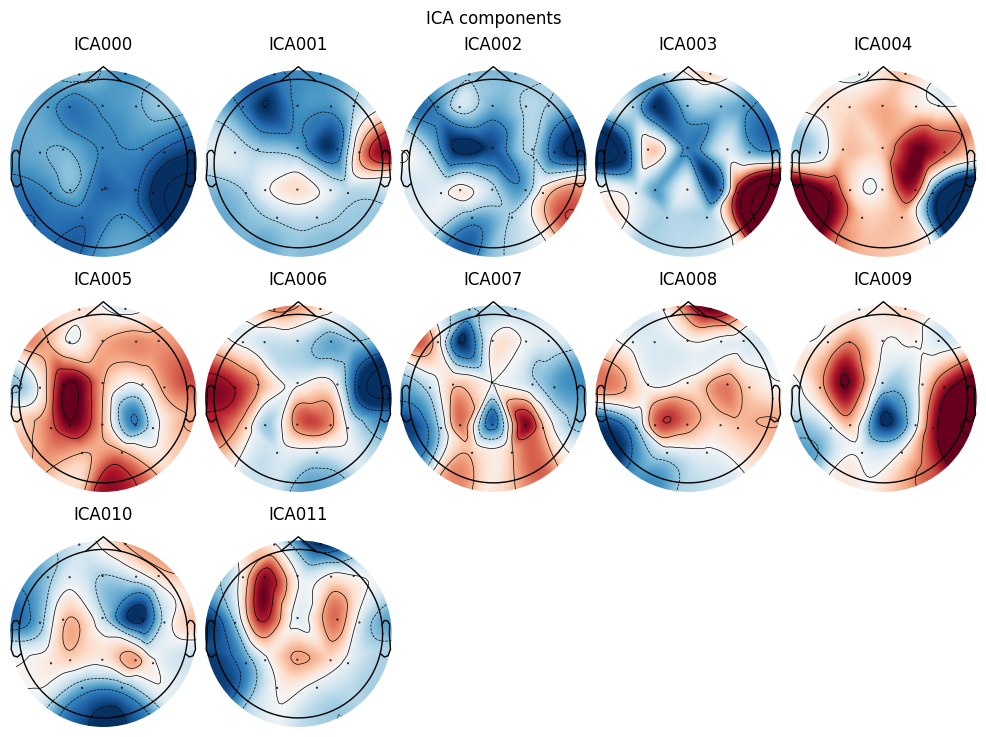

Inspect components and set ica.exclude = [indices]
Example: ica.exclude = [0, 1] for eye blink components
Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


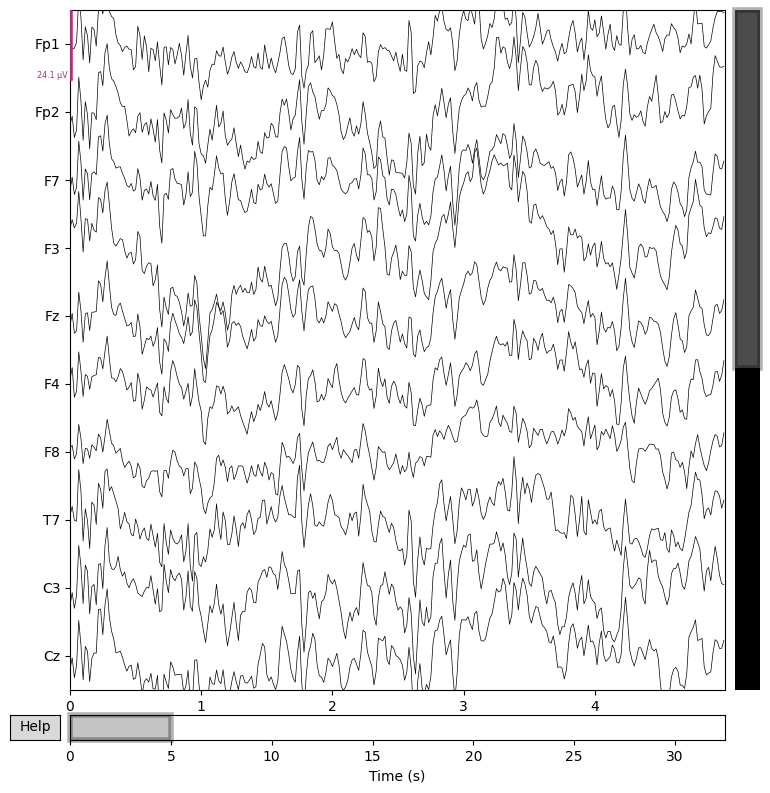

Not setting metadata
15299 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15299 events and 145 original time points ...
15210 bad epochs dropped


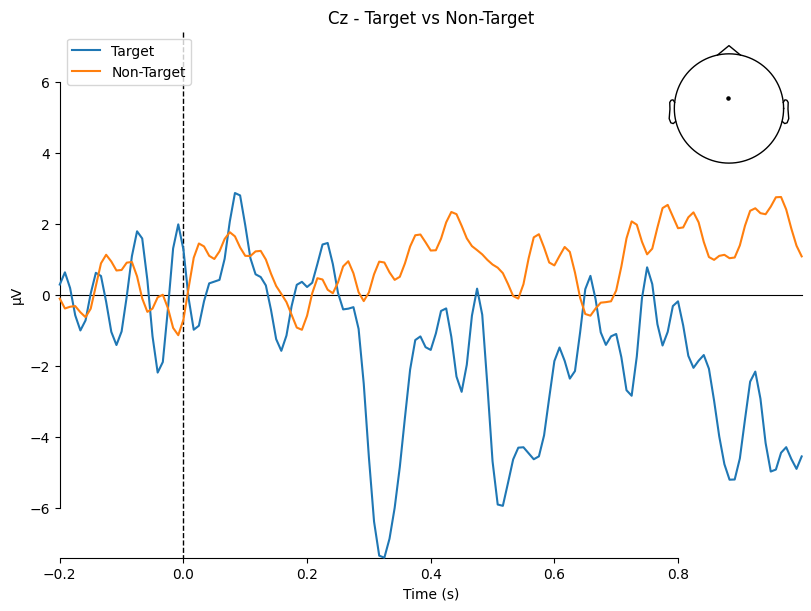

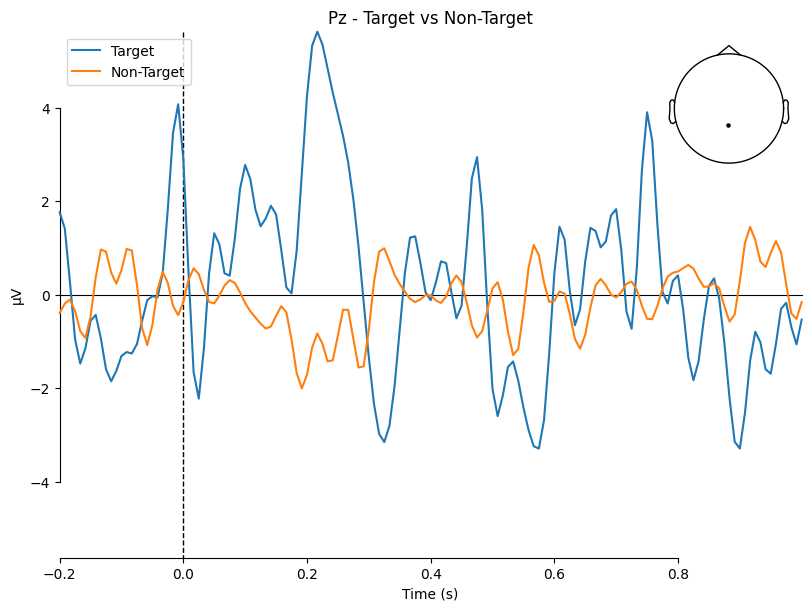

Preprocessing complete!


In [4]:
# 1
!pip install mne
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive
print("imported")
#2
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/EEG speller winter 25/Subject_A_Train.mat'
mat_data = scipy.io.loadmat(file_path)

# 3
eeg_key = 'Signal' if 'Signal' in mat_data else list(mat_data.keys())[-1]
eeg_data = mat_data[eeg_key]
eeg_data = np.concatenate(eeg_data, axis=1)
eeg_data = eeg_data.T
eeg_data = eeg_data * 1e-6

# 4
flashing = mat_data['Flashing'].flatten()
stim_code = mat_data['StimulusCode'].flatten()
stim_type = mat_data['StimulusType'].flatten()

# 5
events = []
for i in range(1, len(flashing)):
    if flashing[i] > 0.5 and flashing[i-1] <= 0.5:
        event_id = 2 if stim_type[i] == 1 else 1
        events.append([i, 0, event_id])
events = np.array(events)

# 6
sfreq = 240
n_channels = eeg_data.shape[0]
ch_names = [f'EEG{i+1}' for i in range(n_channels)]
ch_types = ['eeg'] * n_channels

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# FILTERING
raw.plot_psd(fmax=50, average=True, spatial_colors=False)
plt.title('PSD BEFORE Filtering')
plt.show()

raw.filter(l_freq=0.1, h_freq=20.0, fir_design='firwin')
raw.resample(sfreq=120)

raw.plot_psd(fmax=50, average=True, spatial_colors=False)
plt.title('PSD AFTER Filtering')
plt.show()

#  SET MONTAGE
standard_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz',
                  'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

# First, rename the channels that correspond to the standard names
rename_map = {old: new for old, new in zip(raw.ch_names[:len(standard_names)], standard_names)}
raw.rename_channels(rename_map)

# Then, select only the channels that have been renamed to standard names
# This assumes the user only wants to apply the montage to these specific channels
raw.pick_channels(standard_names)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

#ICA
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97)
ica.fit(raw, reject=dict(eeg=250e-6))
ica.plot_components()

print("Inspect components and set ica.exclude = [indices]")
print("Example: ica.exclude = [0, 1] for eye blink components")
# MANUALLY SET EXCLUDE BASED ON VISUAL INSPECTION
# ica.exclude = [0, 1]

# APPLY ICA
ica.apply(raw)
raw.plot(n_channels=10, duration=5, scalings='auto', title='After ICA')

#EPOCHING
event_dict = {'Non-Target': 1, 'Target': 2}
epochs = mne.Epochs(raw, events, event_id=event_dict,
                    tmin=-0.2, tmax=1.0, baseline=(None, 0),
                    preload=True)

#EVOKED RESPONSES
evoked_target = epochs['Target'].average()
evoked_nontarget = epochs['Non-Target'].average()

mne.viz.plot_compare_evokeds({'Target': evoked_target, 'Non-Target': evoked_nontarget},
                              picks='Cz', title='Cz - Target vs Non-Target')

mne.viz.plot_compare_evokeds({'Target': evoked_target, 'Non-Target': evoked_nontarget},
                              picks='Pz', title='Pz - Target vs Non-Target')

print("Preprocessing complete!")